In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ## https://stackoverflow.com/questions/32834731/how-to-delete-a-file-by-extension-in-python
# ## to delete all .npy files
# import os
# dir_name = '/content/drive/My Drive/Colab Notebooks/Medical data case study'
# test = os.listdir(dir_name)

# for item in test:
#     if item.endswith(".npy"):
#         os.remove(os.path.join(dir_name, item))

In [3]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
from tqdm import tqdm
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
# import tensorflow as tf
import xml.etree.ElementTree
import numpy as np
import pandas as pd 
import re
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [ ]:
print(tf.__version__)

2.3.0


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!pip install -q tqdm

In [ ]:
image_folder = '/content/drive/My Drive/Medical Report Generation using Chest X-Ray/Dataset/xray-images'
annotation_folder = '/content/drive/My Drive/Medical Report Generation using Chest X-Ray/Dataset/ecgen-radiology'

In [ ]:
## https://github.com/wisdal/diagnose-and-explain/blob/master/prepare_dataset.py

def extract_data():
    all_findings = []
    all_impressions = []
    all_img_names = []
    rids = []
    
    total_count = 0 # Count of reports available in the dataset
    no_image_count = 0 # Count of reports having no associated chest image
    no_impression_count = 0 # Count of reports having an empty "Impression" section
    no_findings_count = 0 # Count of reports having an empty "Findings" section

    # Storing impressions, findings and the image names in vectors
    for file in tqdm(os.listdir(annotation_folder)):
      if file.endswith('.xml'):
      # for file in tqdm(annotation_folder):
          total_count += 1
          file = os.path.abspath(annotation_folder) + '/' + file
          e = xml.etree.ElementTree.parse(file).getroot()

          rid = e.find('pmcId').get('id') # Report Id
          # We choose to ignore reports having no associated image
          image_id = e.find('parentImage')
          if image_id is None:
              no_image_count += 1
              continue

          image_id = image_id.get('id')
  #         image_name = os.path.abspath('.') + '/' + image_id + '.png'
          image_name = image_folder + '/' + image_id + '.png'
          findings = ''
          impression = ''

          # Parsing "Impression" and "Findings"
          for element in e.findall('MedlineCitation/Article/Abstract/AbstractText'):
              if element.get('Label') == 'FINDINGS':
                  findings = element.text
              if element.get('Label') == 'IMPRESSION':
                  impression = element.text

          # Sanity check: Skip this report if it has an empty "Impression" section
          if findings is None:
              no_findings_count += 1
              #findings = 'No finding'
              continue
          if impression is None:
              no_impression_count += 1
              continue
          
          # Transforming findings and impressions into lists of sentences
          # https://stackoverflow.com/questions/21840389/python-regular-expression-remove-period-from-number-at-end-of-sentence
          findings = findings.replace("XXXX", "") #"XXXX" represents information anonymized
          findings=re.sub('((\d+)[\.])(?!([\d]+))','\g<2>',findings)
          findings = re.sub(" \d+", " ", findings)
  #         sentences = findings.split('.')
          sentences = findings
  #         del sentences[-1]
  #         sentences = ['<start> ' + sentence + ' <end>' for sentence in sentences]
          # sentences = ['<start> ' + sentences + ' <end>']
          findings = sentences

          impression = impression.replace("XXXX", "") #"XXXX" represents information anonymized
          impression=re.sub('((\d+)[\.])(?!([\d]+))','\g<2>',impression)
          impression = re.sub(" \d+", " ", impression)
  #https://www.tutorialspoint.com/How-to-remove-specific-characters-from-a-string-in-Python
          impression=impression.replace("1", "")
  #         sentences = impression.split('.')
  #         del sentences[-1]
          sentences = impression
  #         sentences = ['<start> ' + sentence + ' <end>' for sentence in sentences]
          sentences = ['<start> ' + sentences + ' <end>' ]
          impression = sentences

          #appending to vectors
          all_img_names.append(image_name)
          all_findings.append(findings)
          all_impressions.append(impression)
          rids.append(rid)

    print("Number of reports available:", total_count)
    print("Number of reports selected:", len(all_img_names))
    print("Number of reports not having images (skipped):", no_image_count)
    print("Number of reports with Impression section empty (skipped):", no_impression_count)
    print("Number of reports with Findings section empty:", no_findings_count)
    print("Total skipped:", no_image_count + no_impression_count + no_findings_count)

    return all_findings, all_impressions, all_img_names, rids

In [ ]:
# all_findings, all_impressions, all_img_names, report_id=extract_data()

 48%|████▊     | 1905/3956 [10:45<11:59,  2.85it/s]

In [ ]:
all_impressions[0]

['<start>  Cardiomegaly with mild vascular prominence. No change. <end>']

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (512, 624))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path  

In [6]:
# # Converting Lists to Dataframe
# # https://stackoverflow.com/questions/30522724/take-multiple-lists-into-dataframe
# df = pd.DataFrame(
#     { 'report_id':report_id,
#         'findings': all_findings,
#      'impressions': all_impressions,
#      'image_names': all_img_names
#     })
# df.to_csv('x_ray_image_with_report.csv') 
df=pd.read_csv('/content/drive/My Drive/Medical Report Generation using Chest X-Ray/Dataset/x_ray_image_with_report.csv')
df.head()

,Unnamed: 0,report_id,findings,impressions,image_names
0,0,3700,Cardiomegaly is present. This is unchanged. Th...,['<start> Cardiomegaly with mild vascular pro...,/content/drive/My Drive/Medical Report Generat...
1,1,366,The heart is normal in size. The mediastinum i...,['<start> No acute disease. <end>'],/content/drive/My Drive/Medical Report Generat...
2,2,3678,The heart is normal in size. The mediastinum i...,['<start> Mild costophrenic blunting suggesti...,/content/drive/My Drive/Medical Report Generat...
3,3,3672,Stable appearance of aortic valve prosthesis. ...,['<start> Mild interstitial edema. <end>'],/content/drive/My Drive/Medical Report Generat...
4,4,3680,The heart is normal in size and contour. There...,"['<start> Vague opacity in the right midlung, ...",/content/drive/My Drive/Medical Report Generat...


In [ ]:
impressions=[]
for i in all_impressions:
  for j in i:
    impressions.append(j)

print(impressions[:1])
all_impressions=impressions  

['<start>  Cardiomegaly with mild vascular prominence. No change. <end>']


In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Get unique images
# all_findings, all_impressions, all_img_names, report_id

encode_train = sorted(set(all_img_names))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [ ]:
# for img, path in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",split=' ', char_level=False,
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_impressions)
train_seqs = tokenizer.texts_to_sequences(all_impressions)
# tokenizer.fit_on_texts(df['impressions'])
# train_seqs = tokenizer.texts_to_sequences(df['impressions'])
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
len(tokenizer.word_index)

1225

In [ ]:
print(all_impressions[3])
print(tokenizer.index_word[10])
print(tokenizer.word_index['<start>'])
print(tokenizer.index_word[1224])  
print(tokenizer.word_index['<start>'])

<start> Mild interstitial edema. <end>
the
2
foreign
2


In [ ]:
# Create the tokenized vectors
# train_seqs = tokenizer.texts_to_sequences(all_impressions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
max_length

114

In [ ]:
train_seqs[10]

[2, 4, 5, 45, 100, 74, 137, 3]

In [ ]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(all_img_names,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(2664, 2664, 667, 667)

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
## https://www.tensorflow.org/tutorials/text/image_captioning
## Code taken from official Tensorflow website

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))



In [ ]:
encoder = CNN_Encoder(embedding_dim) 
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
embedding_dim

256

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
# checkpoint_path = "./checkpoints/train"
checkpoint_path = '/content/drive/My Drive/Medical Report Generation using Chest X-Ray/checkpoints/train'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
len(tokenizer.word_index)

1225

In [ ]:
tokenizer.word_index['<pad>']

0

In [ ]:
tokenizer.index_word[1222]

'bibasal'

In [ ]:
tokenizer.word_index['<start>']

2

In [ ]:
tokenizer.index_word[1225]='<start> '
tokenizer.word_index['<start> '] = 1225
# tokenizer.index_word[1224]=' <end>'
# tokenizer.word_index[' <end>'] = 1224

In [ ]:
# tokenizer.word_index['<start> ']

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
# print(img_tensor.shape)
# print(target.shape)

In [ ]:
EPOCHS = 11
# with strategy.scope():
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.5389
Epoch 1 Loss 0.401613
Time taken for 1 epoch 591.9957253932953 sec

Epoch 2 Batch 0 Loss 0.2865
Epoch 2 Loss 0.331339
Time taken for 1 epoch 168.01895785331726 sec

Epoch 3 Batch 0 Loss 0.3465
Epoch 3 Loss 0.281284
Time taken for 1 epoch 168.13542461395264 sec

Epoch 4 Batch 0 Loss 0.2267
Epoch 4 Loss 0.254351
Time taken for 1 epoch 167.6858148574829 sec

Epoch 5 Batch 0 Loss 0.2444
Epoch 5 Loss 0.234712
Time taken for 1 epoch 168.19053316116333 sec

Epoch 6 Batch 0 Loss 0.2278
Epoch 6 Loss 0.222862
Time taken for 1 epoch 168.41098999977112 sec

Epoch 7 Batch 0 Loss 0.3194
Epoch 7 Loss 0.215288
Time taken for 1 epoch 168.17839908599854 sec

Epoch 8 Batch 0 Loss 0.1754
Epoch 8 Loss 0.206330
Time taken for 1 epoch 167.65031623840332 sec

Epoch 9 Batch 0 Loss 0.1687
Epoch 9 Loss 0.198474
Time taken for 1 epoch 167.89194178581238 sec

Epoch 10 Batch 0 Loss 0.1884
Epoch 10 Loss 0.189818
Time taken for 1 epoch 167.65463495254517 sec

Epoch 11 Batch 0 Loss 0.1797
E

In [ ]:
# ckpt_manager.save()

'/content/drive/My Drive/Medical Report Generation using Chest X-Ray/checkpoints/ckpt-1'

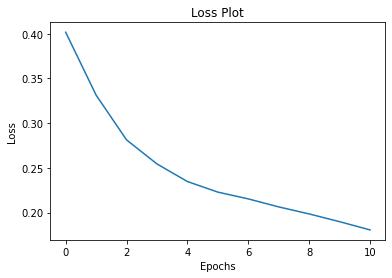

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
[tokenizer.word_index['<start>']]

[2]

In [ ]:
print(img_tensor.shape)
print(target.shape)

(40, 252, 2048)
(40, 114)


In [ ]:
import PIL.Image

def plot_attention(image, result, attention_plot):
    # img_name_to_save=image
    temp_image = np.array(PIL.Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.savefig("figure_latest.png") # save as png
    plt.show()

In [ ]:
def evaluate(image):
    # attention_plot = np.zeros((max_length, attention_features_shape))
    attention_plot = np.zeros((max_length, 252))
    # print('attention plot shape ',attention_plot.shape)
    hidden = decoder.reset_state(batch_size=1) 
    # print("hidden shape", hidden.shape)
    # dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # print("temp input shape", temp_input.shape)
    img_tensor_val = image_features_extract_model(temp_input)
    # print("img tensor val shape", img_tensor_val.shape)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # print("img tensor val shape after reshape", img_tensor_val.shape)
    features = encoder(img_tensor_val)
    # print("Encoder output features shape ", features.shape)
    # dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    dec_input = tf.expand_dims([tokenizer.word_index['<start> ']], 0)
    # print('shape dec input ', dec_input.shape)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # print('attention weights shape ',attention_weights.shape)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

Real Caption: <start> right apical pneumothorax measuring approximately mm in thickness multiple right sided rib fractures involving at the right anterior th through th ribs with mild displacement mild right basilar airspace disease atelectasis versus contusion <end>
Prediction Caption: in right clavicle <end>


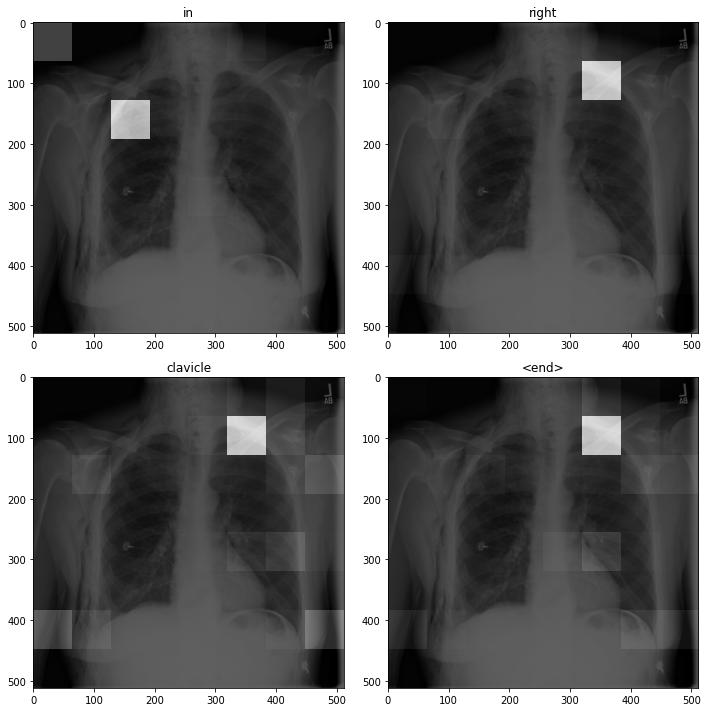

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> hypoinflation with no visible active cardiopulmonary disease <end>
Prediction Caption: to mild nonenlarged effusions no acute cardiopulmonary abnormality <end>


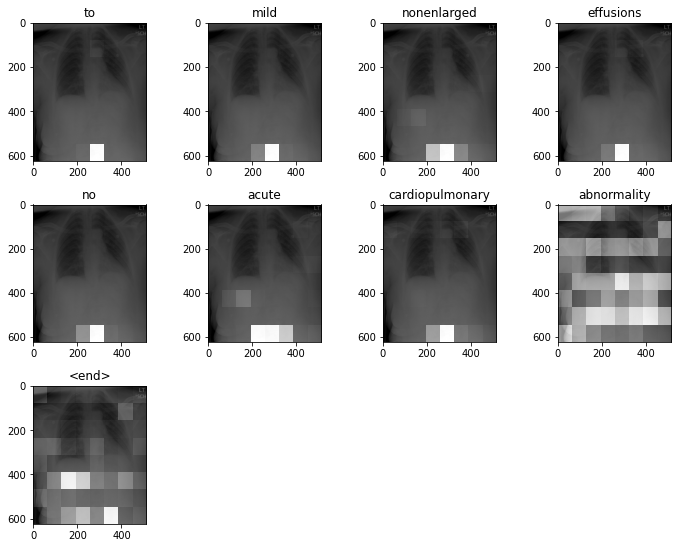

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: <start> chest right th rib fracture no cardiopulmonary injury no pleural air collection right shoulder negative right humerus negative <end>
Prediction Caption: with normal with contrast is clear lungs <end>


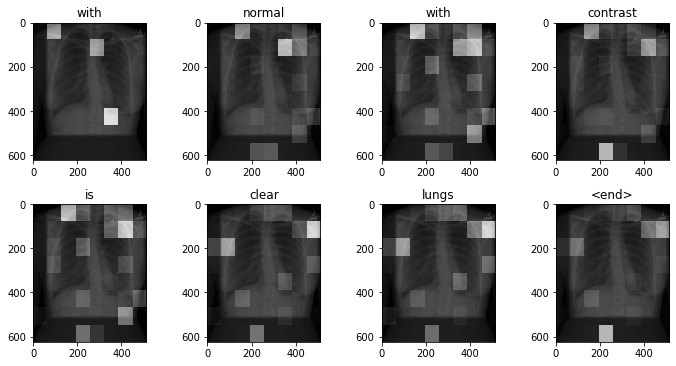

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: <start> unremarkable views of the chest <end>
Prediction Caption: nodular opacity representing tortuous online receipt of the thoracic aorta <end>


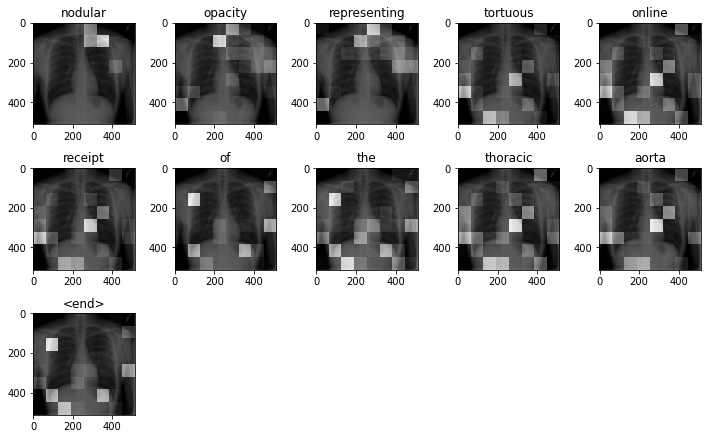

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

# plt.savefig('sample.pdf')

Real Caption: <start> cardiomegaly minimal left midlung atelectasis blunting of left costophrenic this could indicate a small amount of pleural fluid versus pleural parenchymal scarring <end>
Prediction Caption: otherwise no focal infiltrate and mildly lungs or pulmonary edema <end>


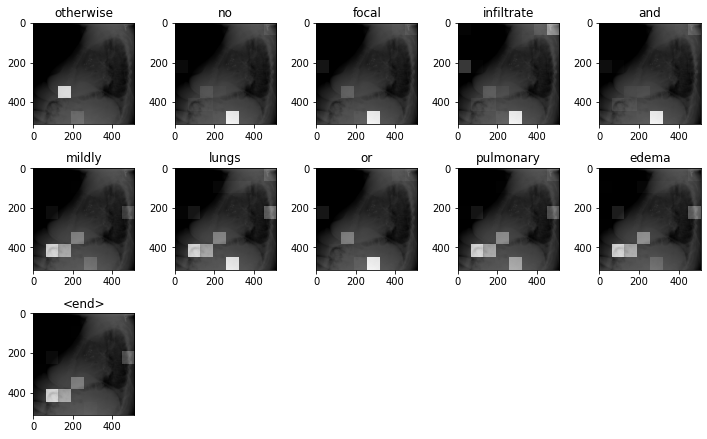

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: <start> low lung volume study no acute pulmonary process <end>
Prediction Caption: radiographs scan followup ct chest x <end>


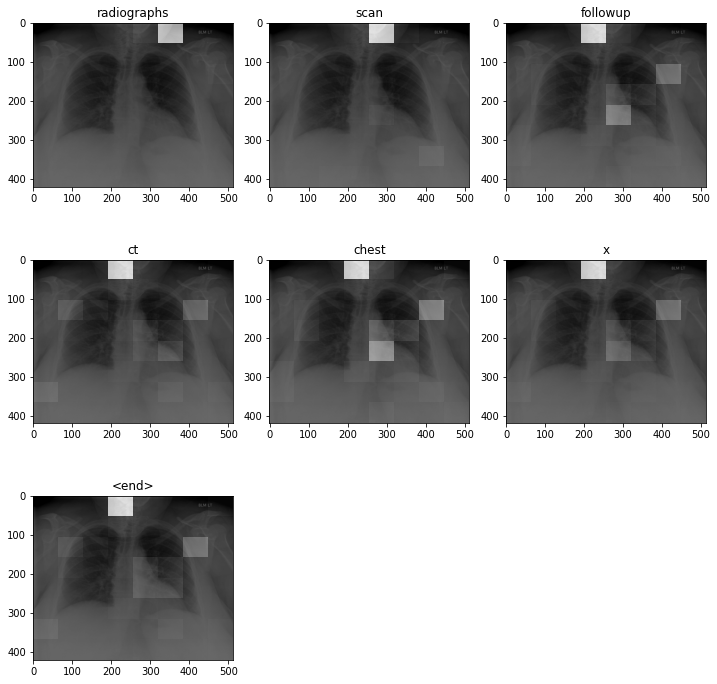

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: <start> stable chronic changes no acute findings <end>
Prediction Caption: exam no evidence of acute cardiopulmonary abnormality age indeterminate ct dedicated views of the chest radiograph <end>


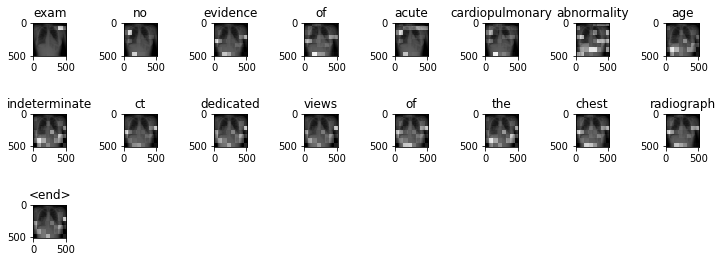

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: <start> no evidence of acute cardiopulmonary process unremarkable examination of the chest <end>
Prediction Caption: of acute cardiopulmonary abnormality identified <end>


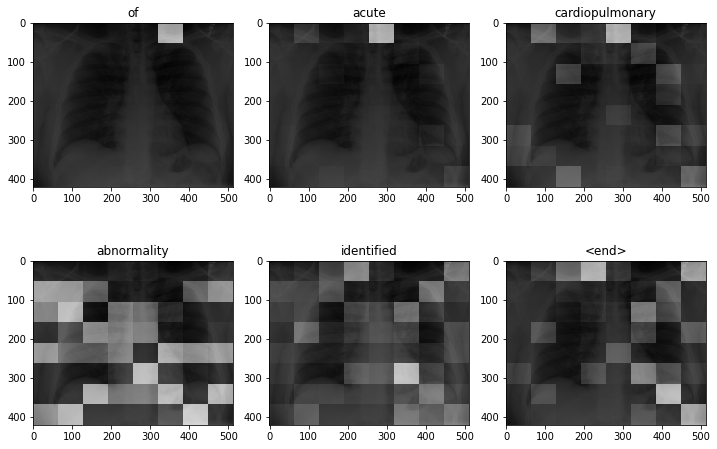

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Taking images online


In [1]:
image_url='https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/X-ray_of_COPD_exacerbation_-_anteroposterior_view.jpg/300px-X-ray_of_COPD_exacerbation_-_anteroposterior_view.jpg'

Prediction Caption: decreasing emphysema without active disease <end>


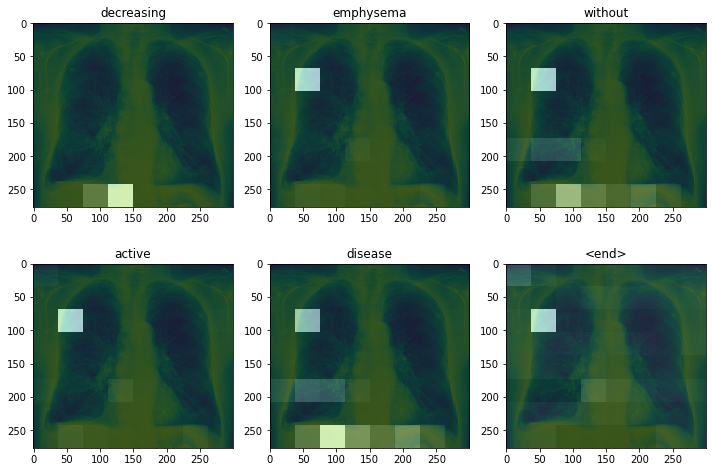

In [ ]:
# image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
# Image.open(image_path)

Prediction Caption: examination <end>


ValueError: ignored

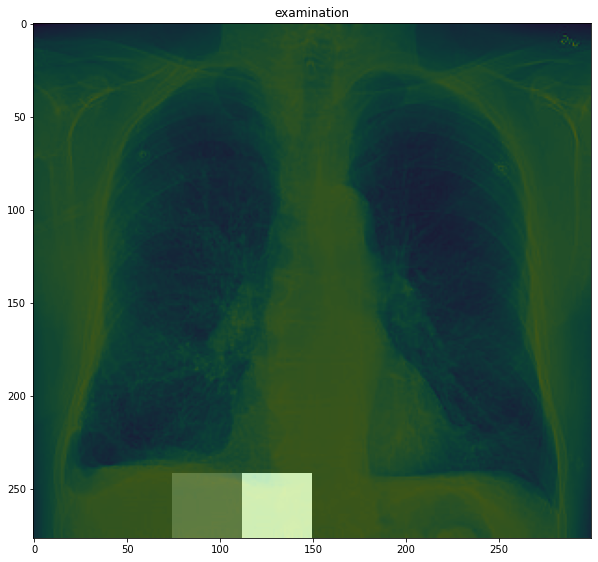

In [ ]:
image_url='https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Chest_radiograph_in_influensa_and_H_influenzae%2C_posteroanterior%2C_annotated.jpg/300px-Chest_radiograph_in_influensa_and_H_influenzae%2C_posteroanterior%2C_annotated.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
# Image.open(image_path)

In [ ]:
# checkpoint_directory = "/tmp/training_checkpoints"
checkpoint_path = '/content/drive/My Drive/Medical Report Generation using Chest X-Ray/checkpoints/train'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")
if ckpt_manager.latest_checkpoint:
  # start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)


In [ ]:
image_url = 'https://static.healthcare.siemens.com/siemens_hwem-hwem_ssxa_websites-context-root/wcm/idc/groups/public/@global/documents/image/mda5/nzgw/~edisp/x-ray-covid-19-header-1920x1080-07267872/~renditions/x-ray-covid-19-header-1920x1080-07267872~7.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
# Image.open(image_path)

65536/58223 [=================================] - 0s 0us/step


NameError: ignored